# Physical Activity Prediction Notebook

## Problem description

With the development of devices such as smartwatches and fitness bands, monitoring physical activity has become easier. Sensors in these devices, such as accelerometers or thermometers, collect data about motion, temperature, and activity intensity. This allows automatic recognition of various activities, such as running, walking, or even swimming.

The main goal of this project is to develop a model that, based on sensor signals, can automatically assign a given data sample to one of the specified activities. This model addresses a multiclass classification problem, where each data sample corresponds to a specific activity.

The classification model developed in this project could find broad application throughout the ecosystem of wearable devices. For example, it could automatically record the user’s physical activity, eliminating the need for manual data input, especially for activities like household chores (e.g., ironing or vacuuming). Precise activity classification allows for more accurate calorie estimation, even in situations where the user has not manually activated an activity-tracking mode. During intensive exercises or sports, the system could suggest to the user the activity identified by the algorithm. Such a solution could significantly enhance smartwatch functionality when used in collaboration with other wearable devices. Through their mutual integration, users could obtain a more comprehensive overview of their daily activity levels, enabling better adaptation of health habits and achievement of fitness goals.

This project seems particularly interesting because it addresses a real-world issue affecting a growing number of wearable device users. As someone who regularly uses a smartwatch, I have frequently encountered situations in which the suggested activity was incorrect. Current systems often neglect low-intensity activities, such as household chores, or incorrectly classify more dynamic activities. This challenge inspires a deeper understanding of how activity classification processes can be improved and what additional data could enhance the outcomes.

## Data

The data used in this project originates from a publicly available dataset – [the Physical Activity Dataset](https://www.kaggle.com/datasets/diegosilvadefrana/fisical-activity-dataset). It was collected using wearable devices such as accelerometers, gyroscopes, and temperature sensors worn by study participants on various parts of their bodies (hand, chest, and ankle). The participants performed diverse physical activities and daily tasks, which were manually labeled and categorized into 13 distinct activity classes.

This dataset can be considered reliable, as it stems from a controlled experiment where activity labels were precisely assigned. The original data is sourced from the UCI Machine Learning Repository – [the PAMAP2 Physical Activity Monitoring Dataset](https://archive.ics.uci.edu/dataset/231/pamap2+physical+activity+monitoring). Currently, the original website is archived, but the content was successfully recovered from the [Internet Archive](https://web.archive.org/web/20241119035931/https://archive.ics.uci.edu/dataset/231/pamap2+physical+activity+monitoring), capturing the website’s state as of November 19, 2024. Information from this archived version helped confirm the nature of the data, further enhancing its credibility.

The dataset used in this project contains 33 columns describing various measurements from wearable devices, such as acceleration (from accelerometers), rotational movements (from gyroscopes), body orientation (from magnetometers), body temperature, heart rate, as well as identifiers for individuals and activities. Data was gathered from 8 participants who performed different physical activities and daily tasks labeled into 13 unique classes: ['transient activities', 'lying', 'sitting', 'standing', 'ironing', 'vacuum cleaning', 'ascending stairs', 'descending stairs', 'walking', 'nordic walking', 'cycling', 'running', 'rope jumping'].

An additional advantage is the diversity of data originating from different sensor locations—hand, chest, and ankle. The hand, having greater freedom of movement, may provide the most varied and informative signals, crucial for activity prediction. Meanwhile, data from the ankle and chest complement the overall picture, providing additional insights particularly important for more dynamic or stable activities.

Moreover, if distinguishing certain activities proves challenging due to their similarity (e.g., walking vs. nordic walking), the data can be grouped into broader categories such as physical, routine, and passive activities. Such an approach not only improves classification effectiveness but also enables users to interpret results in a more practical and intuitive manner.

## How the Problem Was Solved?

To address the physical activity classification problem, two machine learning models were employed: Random Forest and Logistic Regression. Both models were selected due to their effectiveness in solving multiclass classification problems, which are typical tasks in supervised learning ("Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow," 2022).

### 1. Data Analysis

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
import os
for dirname, _, filenames in os.walk('/data/dataset2.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [4]:
# read the data
df = pd.read_csv('../data/dataset2.csv')
df.head()

,activityID,heart_rate,hand temperature (°C),hand acceleration X ±16g,hand acceleration Y ±16g,hand acceleration Z ±16g,hand gyroscope X,hand gyroscope Y,hand gyroscope Z,hand magnetometer X,...,ankle acceleration X ±16g,ankle acceleration Y ±16g,ankle acceleration Z ±16g,ankle gyroscope X,ankle gyroscope Y,ankle gyroscope Z,ankle magnetometer X,ankle magnetometer Y,ankle magnetometer Z,PeopleId
0,transient activities,104.0,30.0,2.37223,8.60074,3.51048,-0.092217,0.056812,-0.015845,14.6806,...,9.65918,-1.65569,-0.099797,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1
1,transient activities,104.0,30.0,2.18837,8.56560,3.66179,-0.024413,0.047759,0.006474,14.8991,...,9.69370,-1.57902,-0.215687,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1
2,transient activities,104.0,30.0,2.37357,8.60107,3.54898,-0.057976,0.032574,-0.006988,14.2420,...,9.58944,-1.73276,0.092914,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1
3,transient activities,104.0,30.0,2.07473,8.52853,3.66021,-0.002352,0.032810,-0.003747,14.8908,...,9.58814,-1.77040,0.054545,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1
4,transient activities,104.0,30.0,2.22936,8.83122,3.70000,0.012269,0.018305,-0.053325,15.5612,...,9.69771,-1.65625,-0.060809,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1


In [5]:
# statistics for all columns
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df.describe()

,heart_rate,hand temperature (°C),hand acceleration X ±16g,hand acceleration Y ±16g,hand acceleration Z ±16g,hand gyroscope X,hand gyroscope Y,hand gyroscope Z,hand magnetometer X,hand magnetometer Y,...,ankle acceleration X ±16g,ankle acceleration Y ±16g,ankle acceleration Z ±16g,ankle gyroscope X,ankle gyroscope Y,ankle gyroscope Z,ankle magnetometer X,ankle magnetometer Y,ankle magnetometer Z,PeopleId
count,2864010.00,2864056.00,2864056.00,2864056.00,2864056.00,2864056.00,2864056.00,2864056.00,2864056.00,2864056.00,...,2864056.00,2864056.00,2864056.00,2864056.00,2864056.00,2864056.00,2864056.00,2864056.00,2864056.00,2864056.00
mean,109.77,32.67,-4.98,3.58,3.17,-0.00,0.03,-0.01,21.25,-14.32,...,9.55,-0.13,-2.46,0.01,-0.03,0.01,-32.72,1.64,16.92,4.49
std,25.83,1.80,5.99,6.26,3.83,1.30,0.88,1.45,24.03,24.09,...,5.67,6.82,3.52,1.07,0.60,1.84,18.89,21.60,20.32,2.36
min,57.00,27.44,-145.37,-104.30,-101.45,-27.80,-22.21,-16.70,-103.94,-200.04,...,-155.07,-157.44,-158.93,-24.00,-18.13,-14.02,-172.87,-137.91,-109.29,1.00
25%,90.00,31.44,-9.04,1.29,0.97,-0.35,-0.20,-0.30,5.35,-29.52,...,9.03,-1.76,-3.64,-0.15,-0.08,-0.31,-42.90,-11.40,3.29,2.00
50%,108.00,33.12,-5.82,3.57,2.96,-0.01,0.01,-0.01,24.28,-16.45,...,9.57,-0.27,-2.36,0.00,-0.00,-0.00,-33.90,1.42,18.17,5.00
75%,125.00,34.00,-0.80,6.59,6.00,0.30,0.24,0.29,39.25,1.77,...,10.01,1.25,-1.06,0.09,0.08,0.06,-19.06,17.35,30.91,7.00
max,202.00,35.50,62.86,155.70,156.95,26.42,16.98,14.34,172.59,121.18,...,157.23,157.29,158.87,17.42,13.59,16.53,97.53,123.31,146.90,8.00


In [6]:
# get the data types of all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864056 entries, 0 to 2864055
Data columns (total 33 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   activityID                 object 
 1   heart_rate                 float64
 2   hand temperature (°C)      float64
 3   hand acceleration X ±16g   float64
 4   hand acceleration Y ±16g   float64
 5   hand acceleration Z ±16g   float64
 6   hand gyroscope X           float64
 7   hand gyroscope Y           float64
 8   hand gyroscope Z           float64
 9   hand magnetometer X        float64
 10  hand magnetometer Y        float64
 11  hand magnetometer Z        float64
 12  chest temperature (°C)     float64
 13  chest acceleration X ±16g  float64
 14  chest acceleration Y ±16g  float64
 15  chest acceleration Z ±16g  float64
 16  chest gyroscope X          float64
 17  chest gyroscope Y          float64
 18  chest gyroscope Z          float64
 19  chest magnetometer X       float64
 20  ch

The dataset contains 33 columns describing various measurements obtained from wearable devices (placed on the hand, chest, and ankle). Data was collected from 8 participants performing different physical activities and daily tasks, categorized into 13 unique activity classes: ['transient activities', 'lying', 'sitting', 'standing', 'ironing', 'vacuum cleaning', 'ascending stairs', 'descending stairs', 'walking', 'nordic walking', 'cycling', 'running', 'rope jumping'].

In [7]:
# check for missing values
df["heart_rate"].isnull().sum().sum()

np.int64(46)

In [8]:
# check which columns have missing values
df.isnull().any()

activityID                   False
heart_rate                    True
hand temperature (°C)        False
hand acceleration X ±16g     False
hand acceleration Y ±16g     False
hand acceleration Z ±16g     False
hand gyroscope X             False
hand gyroscope Y             False
hand gyroscope Z             False
hand magnetometer X          False
hand magnetometer Y          False
hand magnetometer Z          False
chest temperature (°C)       False
chest acceleration X ±16g    False
chest acceleration Y ±16g    False
chest acceleration Z ±16g    False
chest gyroscope X            False
chest gyroscope Y            False
chest gyroscope Z            False
chest magnetometer X         False
chest magnetometer Y         False
chest magnetometer Z         False
ankle temperature (°C)       False
ankle acceleration X ±16g    False
ankle acceleration Y ±16g    False
ankle acceleration Z ±16g    False
ankle gyroscope X            False
ankle gyroscope Y            False
ankle gyroscope Z   

In [9]:
# check how many unique people are in the dataset
df["PeopleId"].unique()

array([1, 2, 3, 4, 5, 6, 7, 8])

In [10]:
# check for duplicates
df.duplicated().sum().sum()

np.int64(0)

In [11]:
# check for unique activities
activities = df["activityID"].unique()
activities

array(['transient activities', 'lying', 'sitting', 'standing', 'ironing',
       'vacuum cleaning', 'ascending stairs', 'descending stairs',
       'walking', 'Nordic walking', 'cycling', 'running', 'rope jumping'],
      dtype=object)

/var/folders/ck/n9z7g7hs3pxbp2l7qjs6nnk80000gn/T/ipykernel_20740/2310364991.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=60)


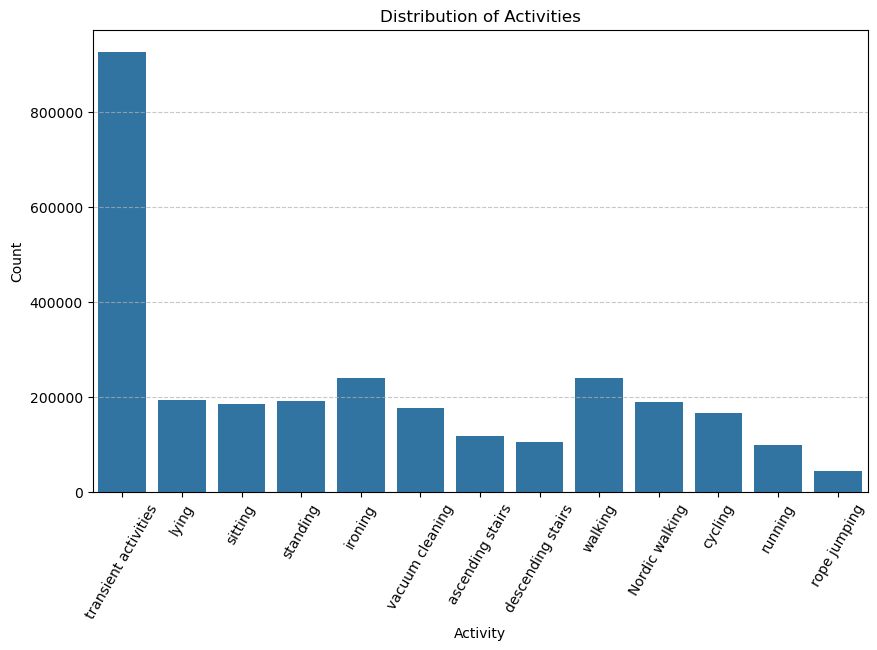

In [12]:
# activity distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='activityID', data=df)
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
plt.title('Distribution of Activities')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.show()

The dataset consists of 2,864,056 records. An analysis of class distribution shows that the data is heavily imbalanced – the most frequent class is 'transient activities' with 927,575 samples, while the smallest class, 'rope jumping', has only 42,969 samples. The 'transient activities' class includes transitional movements, such as changing position from sitting to standing. In the context of this project, this class isn't crucial, as the main objective is to classify stable physical activities that have greater practical significance for the user. Moreover, the transient activities class lacks distinct features that would clearly distinguish it from other activities, making it prone to misclassification. For these reasons, we want to omit 'transient activities' class from the modeling process to focus on more relevant and stable activity classes.

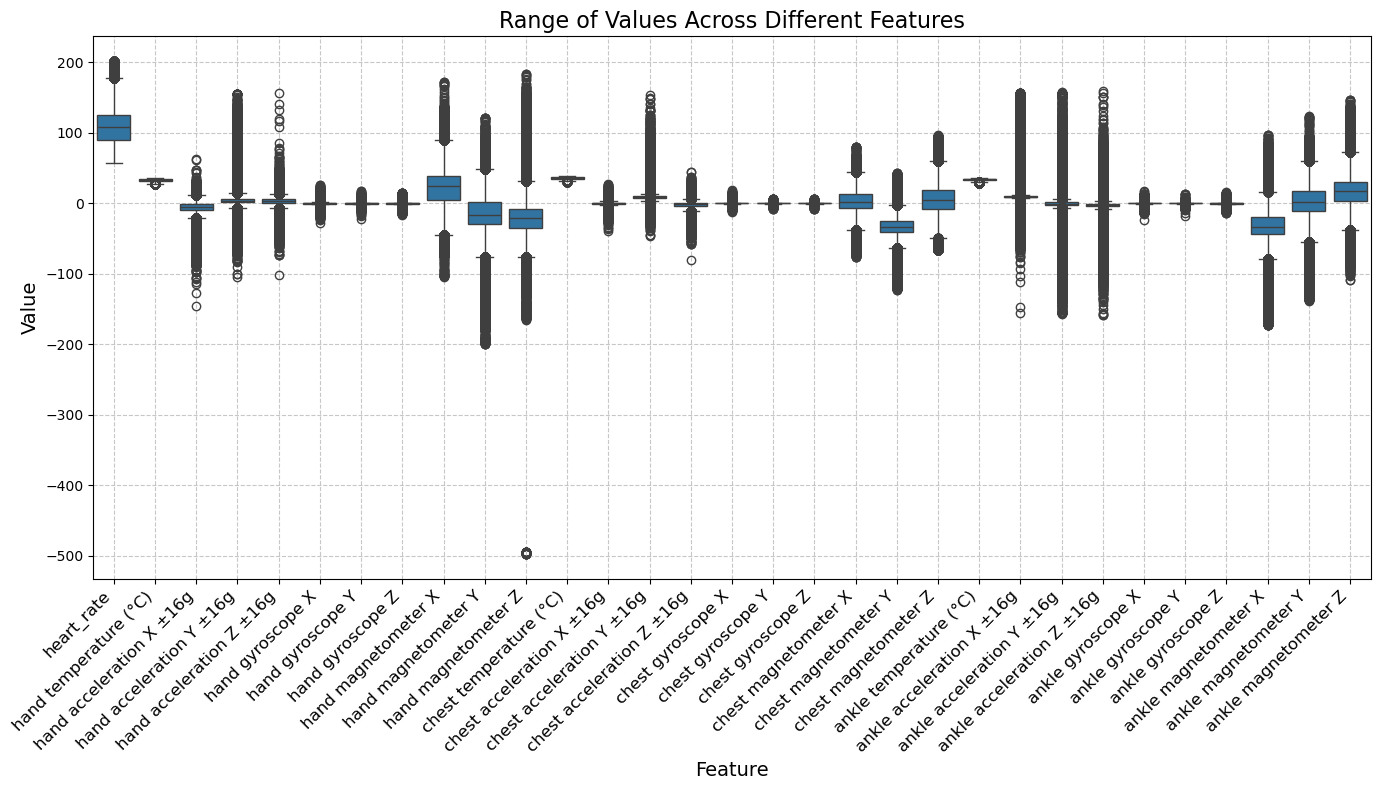

In [13]:
subset = df.drop(["PeopleId", "activityID"], axis=1)

subset_melted = subset.melt(var_name="Feature", value_name="Value")

# boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(x="Feature", y="Value", data=subset_melted)

plt.title('Range of Values Across Different Features', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The dataset's columns exhibit varying value ranges. Sensor data (e.g., accelerometer, magnetometer) displays significant variability, whereas features like temperature and heart rate remain relatively stable. The analysis also uncovered a notable anomaly in the 'hand magnetometer Z' column.

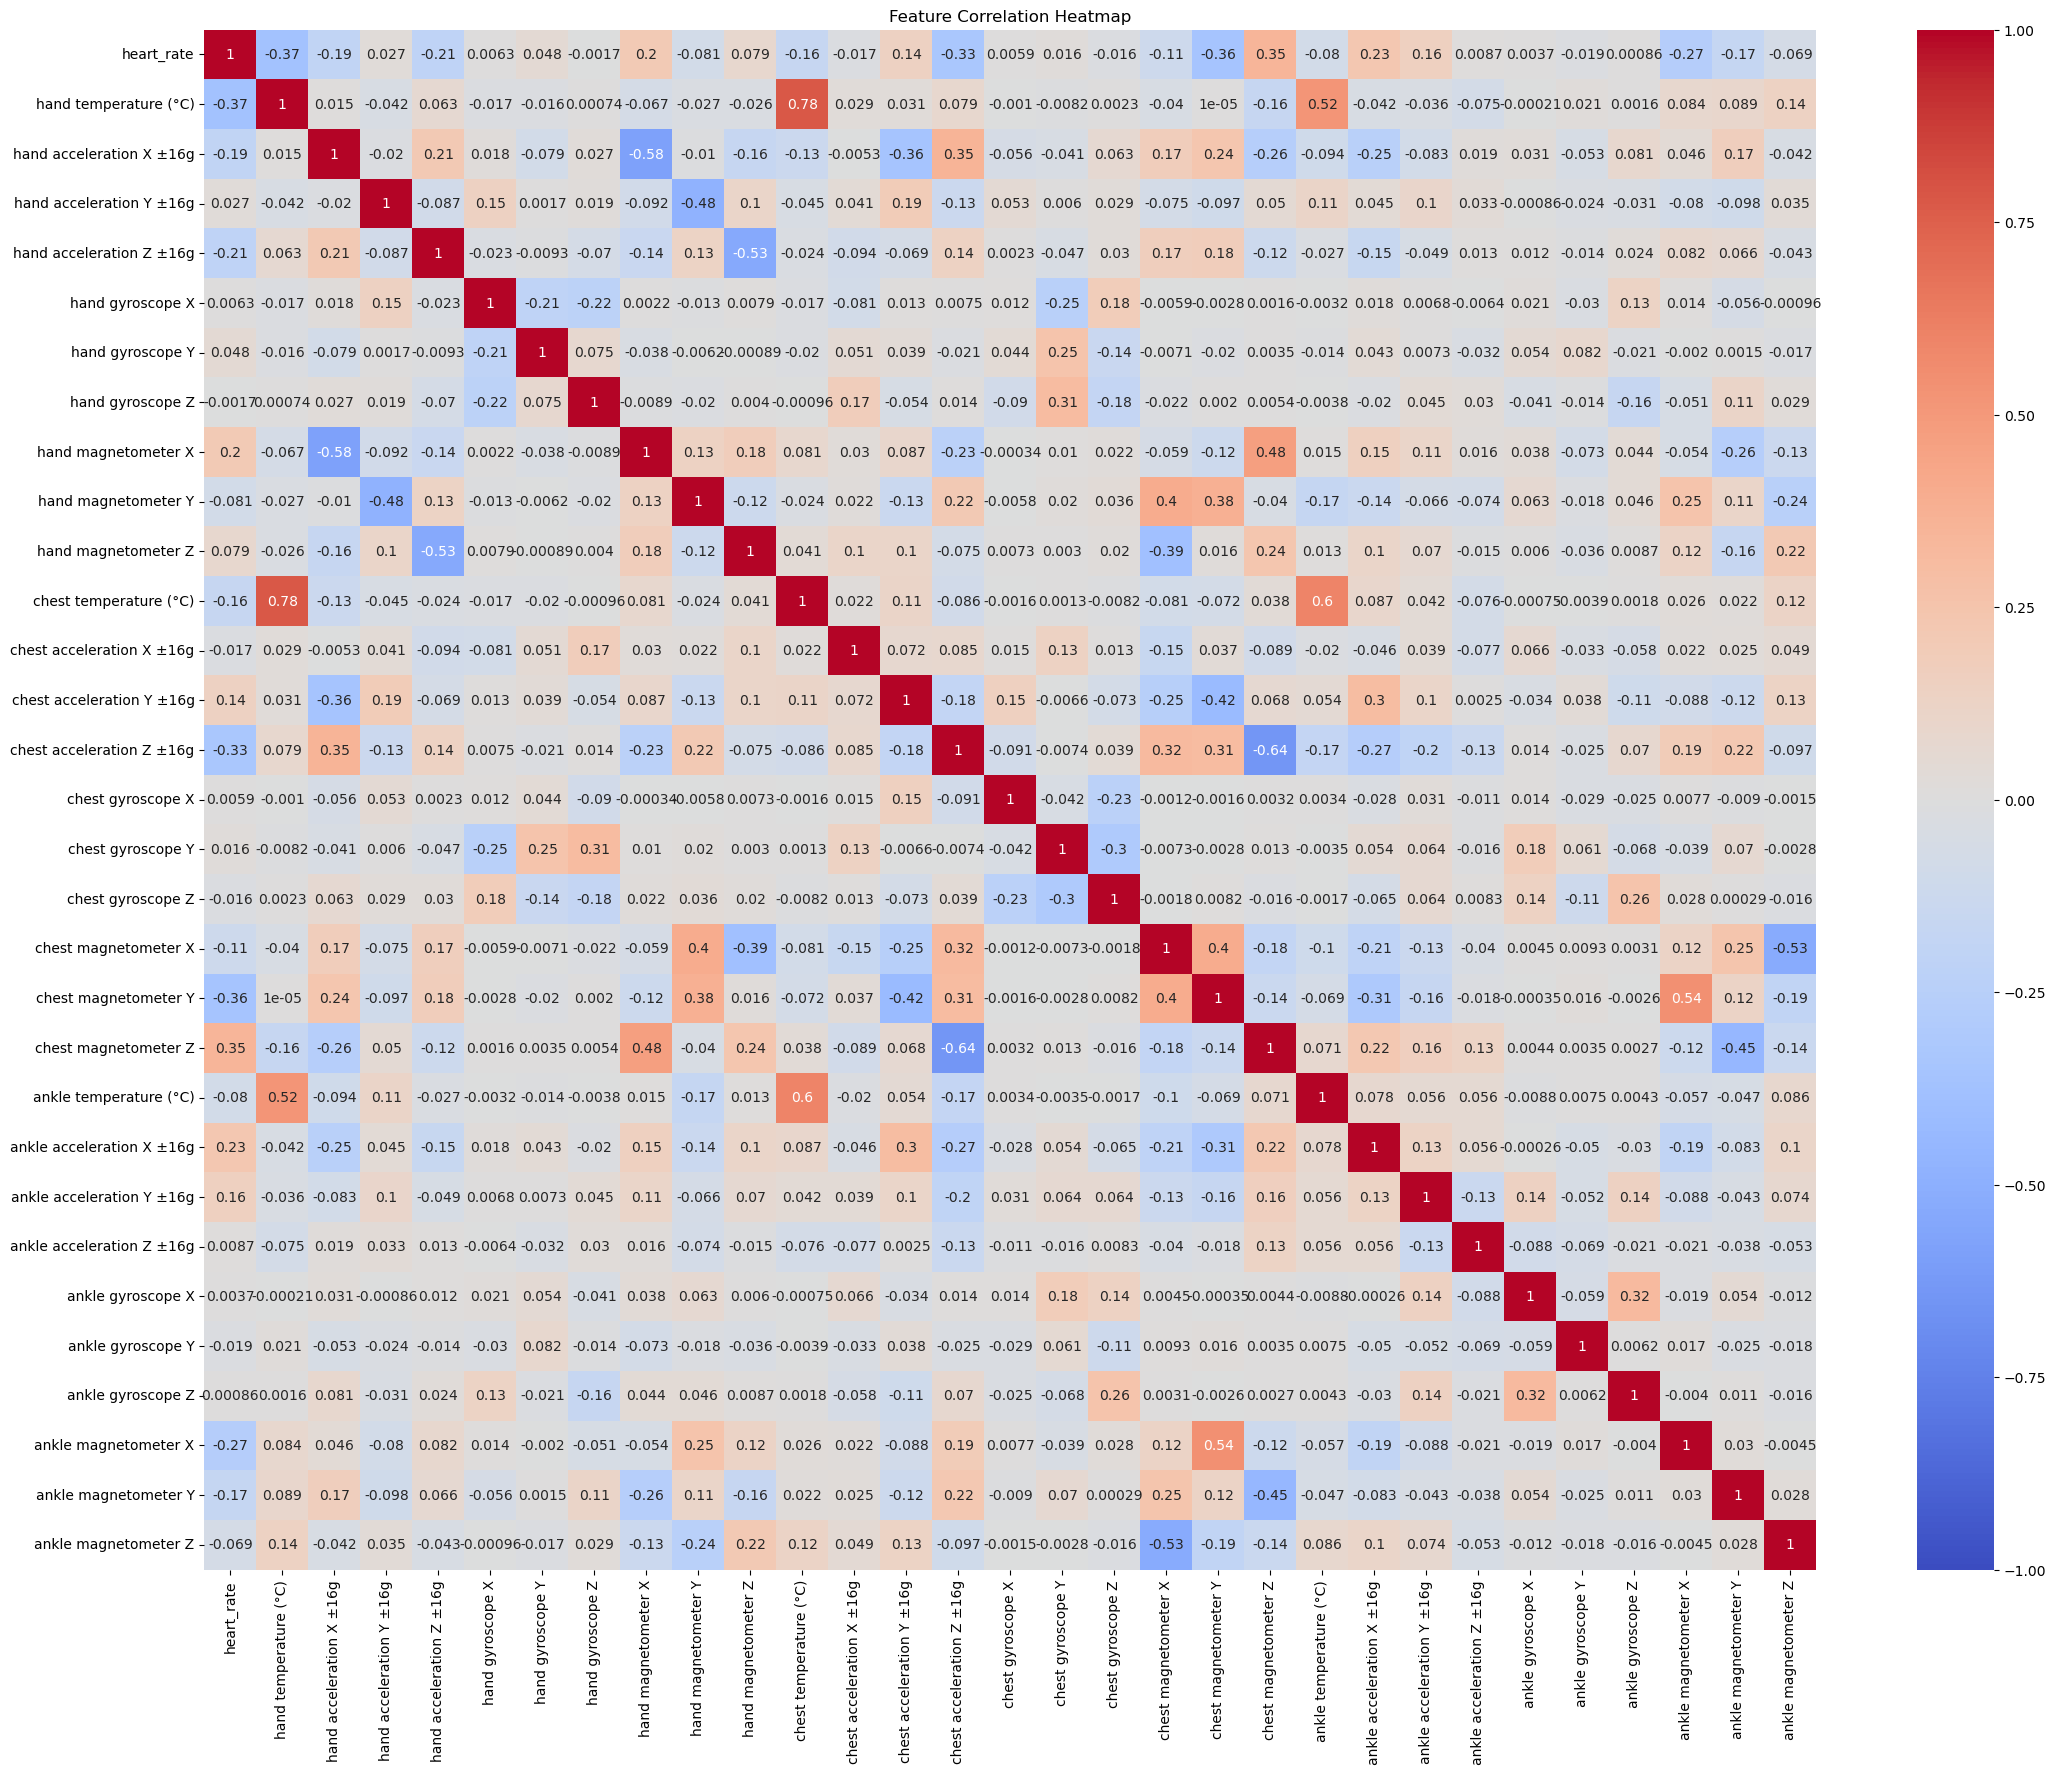

In [14]:
# correlation heatmap
plt.figure(figsize=(26, 20))
sns.heatmap(df.drop(['activityID', 'PeopleId'], axis=1).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.show()

Correlation analysis between columns indicates some redundancy – data from sensors placed in different locations (hand, chest, ankle) show similar patterns, suggesting opportunities for feature reduction through combination or selection. Accelerometer, gyroscope, and magnetometer features measured along specific axes can safely be reduced to magnitudes. Additionally, data from the hand was found to be more diverse and potentially more informative than data from the ankle or chest.

/var/folders/ck/n9z7g7hs3pxbp2l7qjs6nnk80000gn/T/ipykernel_20740/3530716263.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


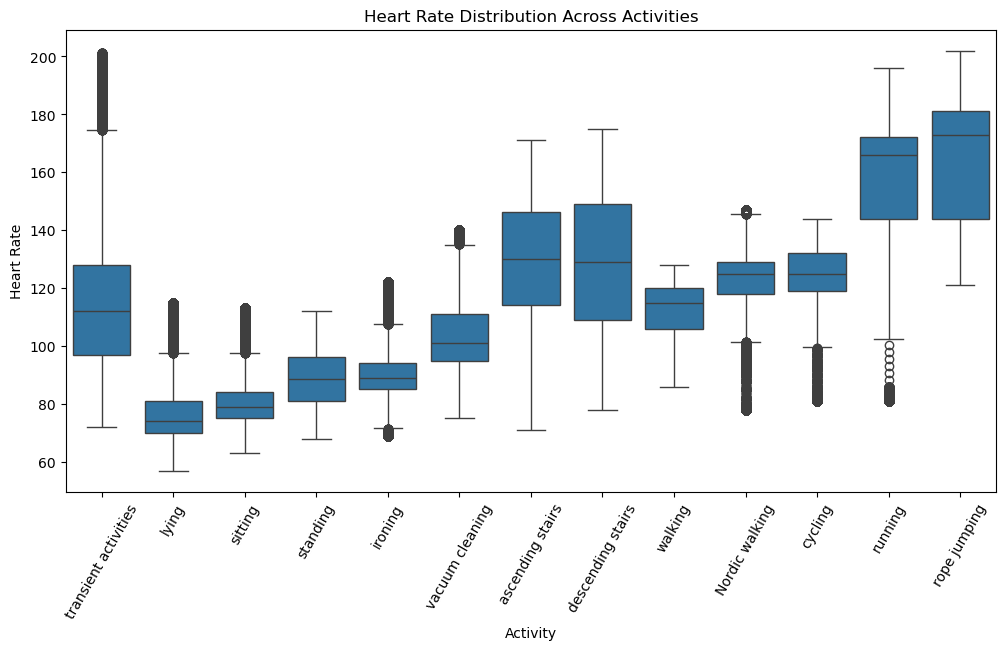

In [15]:
# Heart rate for different activities
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='activityID', y='heart_rate', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.title('Heart Rate Distribution Across Activities')
plt.xlabel('Activity')
plt.ylabel('Heart Rate')
plt.show()

The dataset includes information from 8 participants but lacks detailed demographic data such as gender, age, or fitness level. An analysis of heart rate distributions revealed significant differences between participants, suggesting heart rate values may strongly depend on individual characteristics. Therefore, instead of training the model directly on raw heart rate values, it would be better to use the percentage difference in heart rate for specific activities relative to each individual's median heart rate.

This normalization approach will help the model generalize better to new users, who may vary significantly in age or fitness levels. For instance, older individuals might experience greater heart rate increases during physical activities compared to younger individuals. In the future, incorporating additional demographic data could substantially improve the model's effectiveness in predicting physical activity and personalizing results according to individual differences.

In [16]:
# check for activities every person had
activity_per_person = df.groupby('PeopleId')['activityID'].unique()

people_with_missing_activities = []

all_activities = set(df['activityID'].unique())
for person, activities in activity_per_person.items():
    missing_activities = all_activities - set(activities)
    if missing_activities:
        print(f"Person {person} DOESN'T HAVE such activities: {missing_activities}")
        if person not in people_with_missing_activities:
            people_with_missing_activities.append(person)
    else:
        print(f"Person {person} HAS each activity.")

print(people_with_missing_activities)

Person 1 HAS each activity.
Person 2 HAS each activity.
Person 3 DOESN'T HAVE such activities: {'rope jumping', 'Nordic walking', 'running', 'cycling'}
Person 4 DOESN'T HAVE such activities: {'rope jumping'}
Person 5 HAS each activity.
Person 6 HAS each activity.
Person 7 DOESN'T HAVE such activities: {'rope jumping'}
Person 8 HAS each activity.
[3, 4, 7]


Some participants in the dataset did not perform all activities (e.g., participant 3: {'Nordic walking', 'running', 'cycling', 'rope jumping'}, participant 4: {'rope jumping'}, participant 7: {'rope jumping'}), leading to gaps in samples for certain classes. Such unevenness could negatively impact model testing and validation, as these subsets may not represent the complete range of activities. To avoid potential generalization issues and ensure fair evaluation, it's crucial to assign participants to training, validation, and test sets considering the availability of their performed activities.

### 2. Data Preparation

The first step is to assess the completeness of the data. The analysis showed that the ‘heart rate’ column contained 46 missing values. Given the large number of records in the dataset, these missing entries were removed, which did not negatively impact dataset quality.

In [17]:
# remove rows with missing heart rate values
df = df.dropna(subset=['heart_rate'])

In [18]:
# remove rows with 'transient activities'
df = df[df['activityID'] != 'transient activities']
df.head()

,activityID,heart_rate,hand temperature (°C),hand acceleration X ±16g,hand acceleration Y ±16g,hand acceleration Z ±16g,hand gyroscope X,hand gyroscope Y,hand gyroscope Z,hand magnetometer X,...,ankle acceleration X ±16g,ankle acceleration Y ±16g,ankle acceleration Z ±16g,ankle gyroscope X,ankle gyroscope Y,ankle gyroscope Z,ankle magnetometer X,ankle magnetometer Y,ankle magnetometer Z,PeopleId
2928,lying,100.00,30.38,2.22,8.28,5.59,-0.00,0.04,-0.01,8.93,...,9.74,-1.85,0.10,0.00,-0.03,0.00,-61.11,-36.86,-58.37,1
2929,lying,100.00,30.38,2.29,7.67,5.74,-0.17,0.03,-0.01,9.58,...,9.70,-1.88,-0.02,0.02,0.00,0.01,-60.89,-36.32,-58.37,1
2930,lying,100.00,30.38,2.29,7.14,5.82,-0.24,0.01,0.00,9.06,...,9.70,-1.92,-0.06,-0.04,-0.05,-0.00,-60.34,-35.78,-58.61,1
2931,lying,100.00,30.38,2.22,7.14,5.90,-0.19,0.02,0.01,9.93,...,9.66,-1.85,0.09,-0.03,-0.02,0.03,-60.76,-37.10,-57.88,1
2932,lying,100.00,30.38,2.30,7.26,6.09,-0.07,-0.02,0.00,9.16,...,9.78,-1.89,0.10,0.00,-0.05,-0.01,-60.20,-37.12,-57.88,1


Next, the decision was made to remove the ‘transient activities’ class. This class is not significant to the problem, as the focus lies on classifying stable physical activities. Removing this class also eliminated anomalies found in the ‘hand magnetometer magnitude Z’ column, which contained erroneous values (e.g., -500).

/var/folders/ck/n9z7g7hs3pxbp2l7qjs6nnk80000gn/T/ipykernel_20740/1795100205.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=60)


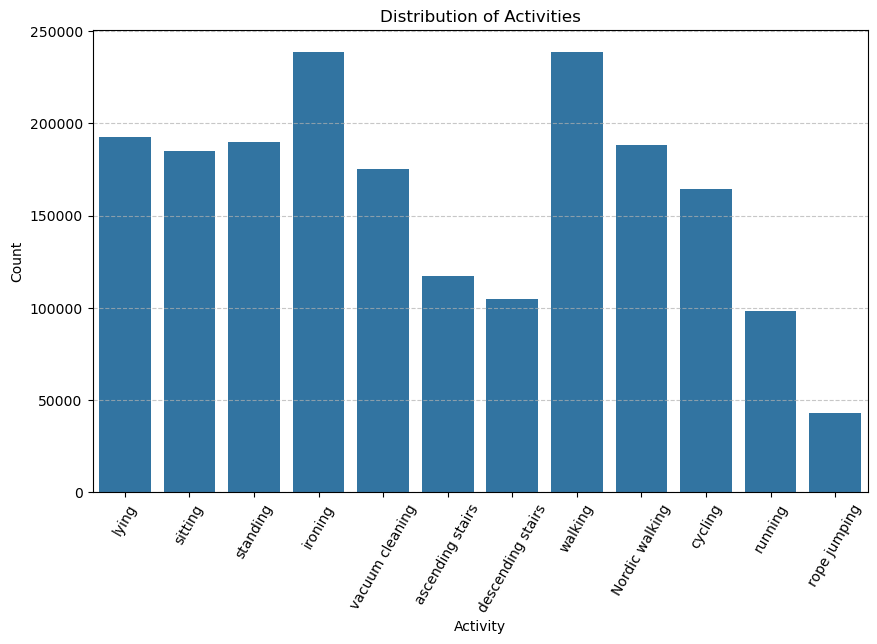

In [19]:
# activity distribution after removing transient activities
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='activityID', data=df)
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
plt.title('Distribution of Activities')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.show()

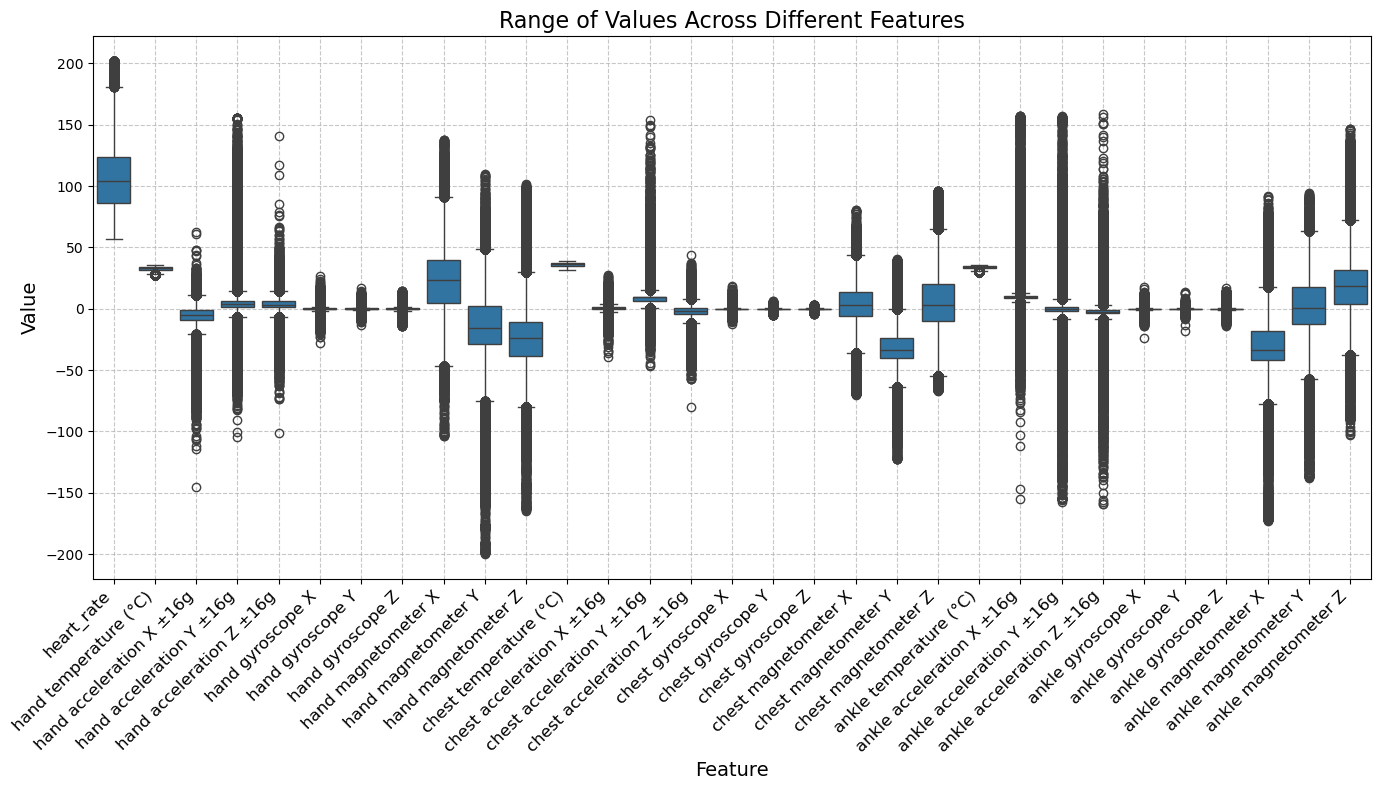

In [20]:
subset = df.drop(["PeopleId", "activityID"], axis=1)

subset_melted = subset.melt(var_name="Feature", value_name="Value")

# boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(x="Feature", y="Value", data=subset_melted)

plt.title('Range of Values Across Different Features', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Another step involved processing heart rate values to account for individual differences such as age or fitness level of participants. For this purpose, a new column named ‘heart_rate_median_diff’ was created, representing the percentage difference in heart rate for a specific activity relative to the median heart rate of the individual. The values were calculated using the following formula:

$$
\text{Heart Rate Change (\%)} = \frac{\text{Heart Rate} - \text{Median Heart Rate}}{\text{Median Heart Rate}} \times 100
$$
This normalization approach enhances the model’s ability to generalize to new users.

In [21]:
# generate a new column with the percentage difference between the heart rate and the median heart rate for each person
df['heart_rate_median_diff'] = ((df['heart_rate'] - df.groupby('PeopleId')['heart_rate'].transform('median')) / df.groupby('PeopleId')['heart_rate'].transform('median')) * 100

df.drop
print(df[['PeopleId', 'heart_rate', 'heart_rate_median_diff']])
df

         PeopleId  heart_rate  heart_rate_median_diff
2928            1      100.00                  -18.70
2929            1      100.00                  -18.70
2930            1      100.00                  -18.70
2931            1      100.00                  -18.70
2932            1      100.00                  -18.70
...           ...         ...                     ...
2844273         8      201.00                   81.08
2844274         8      201.00                   81.08
2844275         8      201.00                   81.08
2844276         8      201.00                   81.08
2844277         8      201.00                   81.08

[1936481 rows x 3 columns]


,activityID,heart_rate,hand temperature (°C),hand acceleration X ±16g,hand acceleration Y ±16g,hand acceleration Z ±16g,hand gyroscope X,hand gyroscope Y,hand gyroscope Z,hand magnetometer X,...,ankle acceleration Y ±16g,ankle acceleration Z ±16g,ankle gyroscope X,ankle gyroscope Y,ankle gyroscope Z,ankle magnetometer X,ankle magnetometer Y,ankle magnetometer Z,PeopleId,heart_rate_median_diff
2928,lying,100.00,30.38,2.22,8.28,5.59,-0.00,0.04,-0.01,8.93,...,-1.85,0.10,0.00,-0.03,0.00,-61.11,-36.86,-58.37,1,-18.70
2929,lying,100.00,30.38,2.29,7.67,5.74,-0.17,0.03,-0.01,9.58,...,-1.88,-0.02,0.02,0.00,0.01,-60.89,-36.32,-58.37,1,-18.70
2930,lying,100.00,30.38,2.29,7.14,5.82,-0.24,0.01,0.00,9.06,...,-1.92,-0.06,-0.04,-0.05,-0.00,-60.34,-35.78,-58.61,1,-18.70
2931,lying,100.00,30.38,2.22,7.14,5.90,-0.19,0.02,0.01,9.93,...,-1.85,0.09,-0.03,-0.02,0.03,-60.76,-37.10,-57.88,1,-18.70
2932,lying,100.00,30.38,2.30,7.26,6.09,-0.07,-0.02,0.00,9.16,...,-1.89,0.10,0.00,-0.05,-0.01,-60.20,-37.12,-57.88,1,-18.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844273,rope jumping,201.00,30.81,-1.57,-9.74,-1.76,-0.02,-0.04,0.03,1.91,...,-0.29,-3.66,0.12,-0.05,-0.10,-32.00,13.27,39.29,8,81.08
2844274,rope jumping,201.00,30.81,-1.64,-9.59,-1.65,-0.03,-0.04,0.03,2.15,...,-0.14,-3.55,0.10,-0.09,-0.08,-31.87,13.27,39.43,8,81.08
2844275,rope jumping,201.00,30.81,-1.79,-9.59,-1.69,-0.01,-0.02,0.03,2.15,...,-0.22,-3.97,0.09,-0.04,-0.10,-31.87,13.27,39.01,8,81.08
2844276,rope jumping,201.00,30.81,-1.65,-9.51,-1.92,-0.03,-0.07,0.02,2.04,...,-0.14,-3.86,0.04,-0.02,-0.07,-31.09,12.58,39.15,8,81.08


In [22]:
# count outliers according to the standard formula (Q1 - 1.5 * IQR) or (Q3 + 1.5 * IQR)
def count_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
    return outliers

outliers = count_outliers(df.drop(['activityID', 'PeopleId'], axis=1))
print(outliers)

heart_rate                    11140
hand temperature (°C)         14542
hand acceleration X ±16g      21224
hand acceleration Y ±16g     125718
hand acceleration Z ±16g      29940
hand gyroscope X             319108
hand gyroscope Y             337345
hand gyroscope Z             429097
hand magnetometer X            6482
hand magnetometer Y           25636
hand magnetometer Z           20644
chest temperature (°C)            0
chest acceleration X ±16g    125131
chest acceleration Y ±16g    206290
chest acceleration Z ±16g    192494
chest gyroscope X            293782
chest gyroscope Y            312892
chest gyroscope Z            276377
chest magnetometer X          33128
chest magnetometer Y         208271
chest magnetometer Z          10501
ankle temperature (°C)        27473
ankle acceleration X ±16g    650962
ankle acceleration Y ±16g    322554
ankle acceleration Z ±16g    138199
ankle gyroscope X            548335
ankle gyroscope Y            479611
ankle gyroscope Z           

All of these outliers are important for this project as they can represent sudden movement in an activity. We cannot just simply get rid of them but we have to use RobustScaler (for those algothithms which are sensitive to the outliers) to make the models precit better.

In [23]:
# prepare data for the model
df_prepared = df[[
    'activityID',
    'PeopleId',
    'heart_rate_median_diff'
    ]]

To simplify data analysis and speed up model training, the data from X, Y, and Z axes for accelerometers, gyroscopes, and magnetometers were combined into single vector magnitudes. These calculations followed the formula (“Magnitude of a Vector”, 2022):

$$
\text{PartOfBody\_Device\_Magnitude} = \sqrt{(\text{PartOfBody Device X})^2 + (\text{PartOfBody Device Y})^2 + (\text{PartOfBody Device Z})^2}
$$

 
This transformation reduced the number of features, allowing a greater focus on key patterns.

After processing, correlation analysis revealed that data from different sensor locations (hand, chest, ankle) provide unique information, justifying their inclusion in the model. It was also noted that features related to magnetometers are highly correlated, potentially allowing further feature optimization in future iterations.

In [24]:
# add new features
df_prepared['temperature_mean'] = df[['hand temperature (°C)', 'chest temperature (°C)', 'ankle temperature (°C)']].mean(axis=1)
df_prepared['temperature_std'] = df[['hand temperature (°C)', 'chest temperature (°C)', 'ankle temperature (°C)']].std(axis=1)

df_prepared['hand_magnetometer_magnitude'] = np.sqrt(
    df['hand magnetometer X']**2 +
    df['hand magnetometer Y']**2 +
    df['hand magnetometer Z']**2
)

df_prepared['chest_magnetometer_magnitude'] = np.sqrt(
    df['chest magnetometer X']**2 +
    df['chest magnetometer Y']**2 +
    df['chest magnetometer Z']**2
)

df_prepared['anckle_magnetometer_magnitude'] = np.sqrt(
    df['ankle magnetometer X']**2 +
    df['ankle magnetometer Y']**2 +
    df['ankle magnetometer Z']**2
)

df_prepared['hand_acceleration_magnitude'] = np.sqrt(
    df['hand acceleration X ±16g']**2 +
    df['hand acceleration Y ±16g']**2 +
    df['hand acceleration Z ±16g']**2
)

df_prepared['chest_acceleration_magnitude'] = np.sqrt(
    df['chest acceleration X ±16g']**2 +
    df['chest acceleration Y ±16g']**2 +
    df['chest acceleration Z ±16g']**2
)

df_prepared['ankle_acceleration_magnitude'] = np.sqrt(
    df['ankle acceleration X ±16g']**2 +
    df['ankle acceleration Y ±16g']**2 +
    df['ankle acceleration Z ±16g']**2
)

df_prepared['hand_gyroscope_magnitude'] = np.sqrt(
    df['hand gyroscope X']**2 +
    df['hand gyroscope Y']**2 +
    df['hand gyroscope Z']**2
)
df_prepared['chest_gyroscope_magnitude'] = np.sqrt(
    df['chest gyroscope X']**2 +
    df['chest gyroscope Y']**2 +
    df['chest gyroscope Z']**2
)
df_prepared['ankle_gyroscope_magnitude'] = np.sqrt(
    df['ankle gyroscope X']**2 +
    df['ankle gyroscope Y']**2 +
    df['ankle gyroscope Z']**2
)

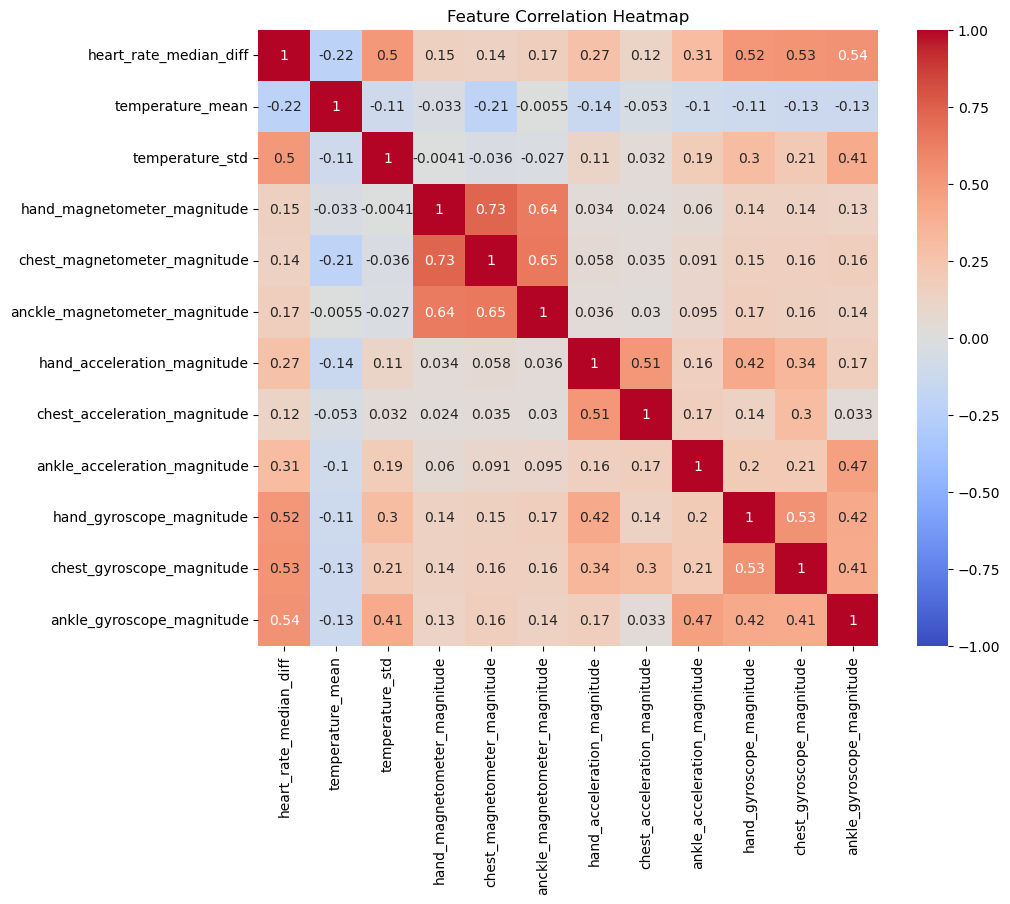

In [25]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_prepared.drop(['activityID', 'PeopleId'], axis=1).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.show()

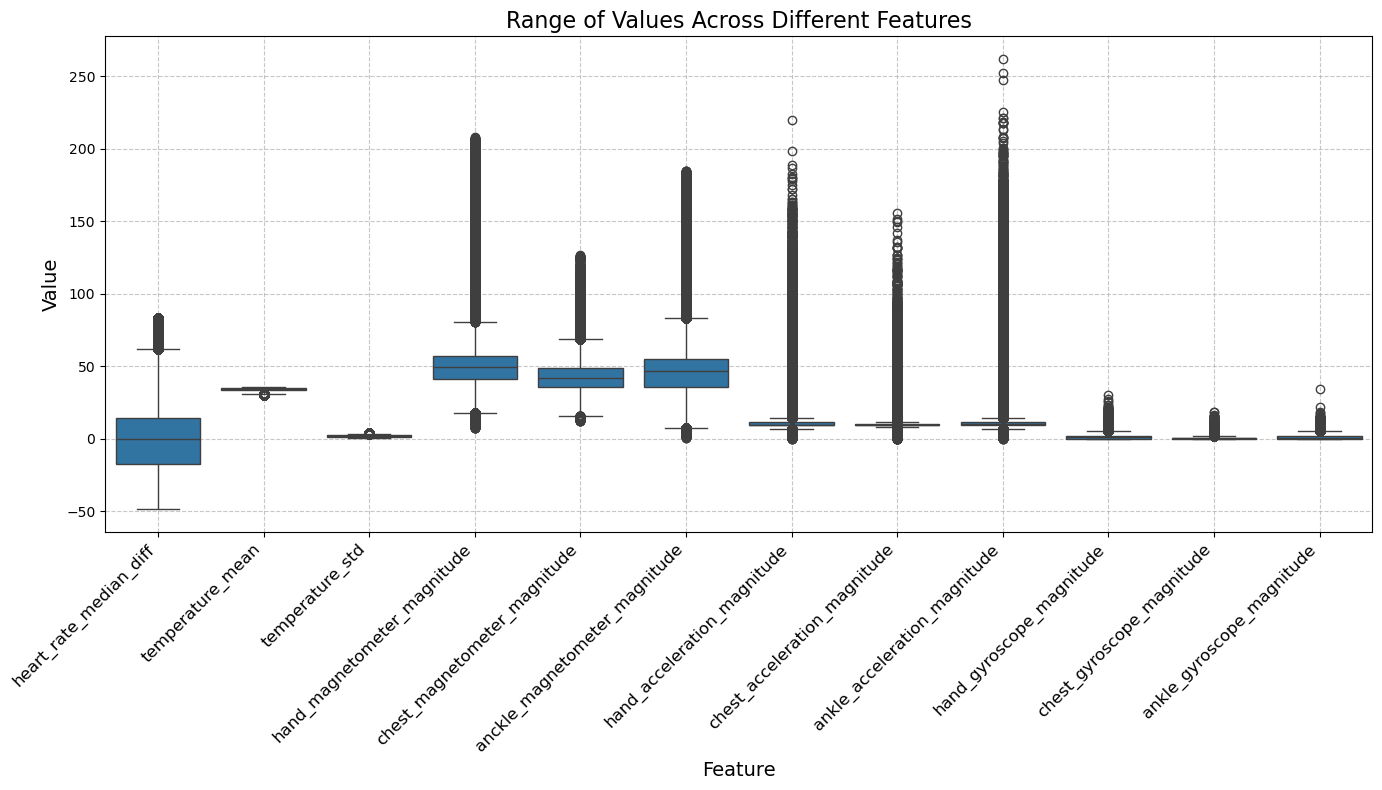

In [26]:
subset = df_prepared.drop(["PeopleId", "activityID"], axis=1)

subset_melted = subset.melt(var_name="Feature", value_name="Value")

plt.figure(figsize=(14, 8))
sns.boxplot(x="Feature", y="Value", data=subset_melted)

plt.title('Range of Values Across Different Features', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
df_prepared.head()

,activityID,PeopleId,heart_rate_median_diff,temperature_mean,temperature_std,hand_magnetometer_magnitude,chest_magnetometer_magnitude,anckle_magnetometer_magnitude,hand_acceleration_magnitude,chest_acceleration_magnitude,ankle_acceleration_magnitude,hand_gyroscope_magnitude,chest_gyroscope_magnitude,ankle_gyroscope_magnitude
2928,lying,1,-18.70,31.10,0.96,71.37,67.33,92.20,10.23,9.79,9.91,0.04,0.07,0.03
2929,lying,1,-18.70,31.10,0.96,71.75,66.69,91.83,9.86,9.79,9.88,0.17,0.07,0.02
2930,lying,1,-18.70,31.10,0.96,70.75,67.16,91.42,9.50,9.91,9.89,0.24,0.06,0.06
2931,lying,1,-18.70,31.10,0.96,71.20,66.49,91.76,9.53,9.88,9.84,0.19,0.09,0.05
2932,lying,1,-18.70,31.10,0.96,70.72,66.44,91.40,9.75,9.88,9.96,0.07,0.04,0.05


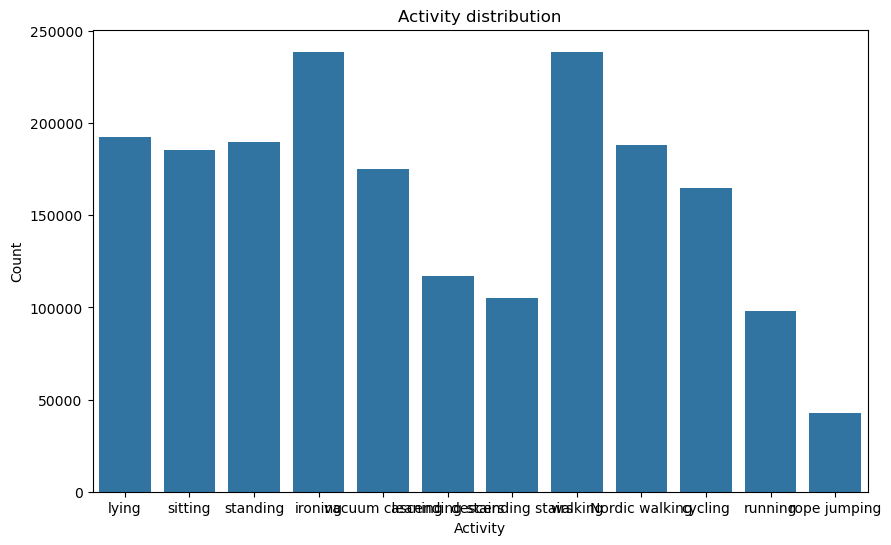

In [28]:
# activity distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=df_prepared['activityID'])
plt.title("Activity distribution")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.show()


Subsequently, the ‘activitiesID’ column was encoded numerically to simplify the modeling process. The class assignment is as follows:
```
{'Nordic walking': 0, 'ascending stairs': 1, 'cycling': 2, 'descending stairs': 3,
'ironing': 4, 'lying': 5, 'rope jumping': 6, 'running': 7,
'sitting': 8, 'standing': 9, 'vacuum cleaning': 10, 'walking': 11}

```

In [29]:
# encode the activityID column
label_encoder = LabelEncoder()

df_prepared['activityID'] = label_encoder.fit_transform(df_prepared['activityID'])

# mapping for further mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print(label_mapping)


{'Nordic walking': np.int64(0), 'ascending stairs': np.int64(1), 'cycling': np.int64(2), 'descending stairs': np.int64(3), 'ironing': np.int64(4), 'lying': np.int64(5), 'rope jumping': np.int64(6), 'running': np.int64(7), 'sitting': np.int64(8), 'standing': np.int64(9), 'vacuum cleaning': np.int64(10), 'walking': np.int64(11)}


The dataset was then split into training, validation, and test sets based on individual participants, to avoid potential data leakage between sets. If data from the same person appeared in more than one set, the models could inadvertently learn user-specific patterns, inflating validation and test set results. To ensure a fair evaluation, each participant was assigned exclusively to one of these sets. Participants who lacked certain activities (3 participants) were distributed so that one participant appeared in each set (training, validation, and test). The final split was as follows: training set – 4 participants, validation set – 2 participants, test set – 2 participants.

Referring to the work of other Kaggle.com users, it is evident that trained models have achieved high accuracy ([99.92%](https://www.kaggle.com/code/maheshbabukamepalli/physical-activity-prediction), [96-99%](https://www.kaggle.com/code/manvinagdev/physical-activity-prediction#Training-RandomForestClassifier)). However, the key challenge remains when the model is applied to data from a new user whose movement patterns were not previously included in the training process. In many previous studies, models were trained on datasets that included all participants. This training approach allowed the model to recognize individual movement patterns and associate them with specific individuals, which may have led to inflated accuracy scores in terms of generalization to new data.

In [ ]:
import os
import json
import numpy as np

split_file = "split_ids.json"

if os.path.exists(split_file):
    # Load existing split
    with open(split_file, "r") as f:
        split_assignment = json.load(f)
    train_people = split_assignment["train"]
    validation_people = split_assignment["val"]
    test_people = split_assignment["test"]
    print("Loaded split from split_ids.json")

else:
    # Generate new deterministic split
    all_people = set(df_prepared['PeopleId'].unique())

    people_with_all_activities = list(all_people - set(people_with_missing_activities))
    np.random.shuffle(people_with_all_activities)
    
    missing_people = list(people_with_missing_activities)
    np.random.shuffle(missing_people)

    # assign people for test set
    test_people = [missing_people[0]] + people_with_all_activities[:1]
    remaining_people = people_with_all_activities[1:]

    # assign people for train and validation sets
    train_people_from_remaining, validation_people = train_test_split(
        remaining_people, test_size=0.2, random_state=42
    )
    
    train_people = train_people_from_remaining + [missing_people[1]]
    validation_people += [missing_people[2]]

    split_assignment = {
        "train": list(map(int, train_people)),
        "val": list(map(int, validation_people)),
        "test": list(map(int, test_people))
    }

    with open(split_file, "w") as f:
        json.dump(split_assignment, f)
    print("Saved new split to split_ids.json")

TypeError: Object of type int64 is not JSON serializable

In [ ]:
# split based on people
train_data = df_prepared[df_prepared['PeopleId'].isin(train_people)]
validation_data = df_prepared[df_prepared['PeopleId'].isin(validation_people)]
test_data = df_prepared[df_prepared['PeopleId'].isin(test_people)]

In [ ]:
X_train, y_train = train_data.drop(['activityID', 'PeopleId'], axis=1), train_data['activityID']
X_val, y_val = validation_data.drop(['activityID', 'PeopleId'], axis=1), validation_data['activityID']
X_test, y_test = test_data.drop(['activityID', 'PeopleId'], axis=1), test_data['activityID']

In [ ]:
# check the distribution of people in each set
train_people_ids = train_data['PeopleId'].unique()
validation_people_ids = validation_data['PeopleId'].unique()
test_people_ids = test_data['PeopleId'].unique()

print("People in the training set:", train_people_ids)
print("People in the validation set:", validation_people_ids)
print("People in the test set", test_people_ids)

In [ ]:
y_train

In [ ]:
y_train_series = pd.Series(y_train)
y_train_series.value_counts().plot(kind='bar', title='Class Distribution in Train Set')

In [ ]:
y_train_series.value_counts()

In [ ]:
X_train_bal, y_train_bal = X_train, y_train

In [ ]:
print(f"X_train_bal shape: {X_train_bal.shape}")
print(f"y_train_bal shape: {y_train_bal.shape}")

In [ ]:
X_train.head()

The final stage in data preparation addressed the issue of data imbalance. Even after removing the 'transient activities' class, the activity distribution still showed substantial class imbalance. Despite this, methods such as undersampling were rejected to avoid the loss of valuable data.

## Model Training and Validation 

At the beginning, preliminary tests of each model were conducted without fine-tuning on the validation and test sets to identify the algorithm that performed best overall. 

The goal of this analysis was to quickly determine the most promising model for further fine-tuning, followed by a detailed evaluation on the test set.

### 1. Random Forest

The Random Forest model, in its baseline configuration, achieved 100% accuracy on the training set, which clearly indicates overfitting, as the validation set accuracy was only 49% ([“Overfitting”, 2019](https://en.wikipedia.org/wiki/Overfitting)). 

To reduce overfitting, the following modifications were applied:
- Limited the maximum tree depth to 4
- Reduced the number of trees to 20
- Applied class weighting as ‘balanced'

After these adjustments, accuracy improved to 80% on the training set and 55% on the validation set, indicating a more balanced model.

Analysis of the results showed that the model struggled the most with the ‘ascending stairs’ and ‘descending stairs’ classes, which were frequently confused. Additionally, on the validation set, ‘nordic walking’ and ‘running’ were often misclassified as ‘rope jumping’, likely due to the imbalanced data distribution.

Further tests were conducted to assess the impact of different scaling methods (StandardScaler, RobustScaler, MinMaxScaler), but none of them significantly improved model performance.


In [ ]:
# import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, RandomizedSearchCV

In [ ]:
X_train_scaled = X_train_bal
X_val_scaled = X_val
X_test_scaled = X_test

In [ ]:
# initialize the model
rf_model = RandomForestClassifier(random_state=42, 
                                  class_weight="balanced",
                                  n_jobs=-1,
                                  n_estimators=20, 
                                  max_depth=4,
                                  )

# train on the training data
rf_model.fit(X_train_scaled, y_train_bal)

# predict on the validation data
y_pred_val = rf_model.predict(X_val_scaled)

In [ ]:
# find the best parameters for the model
param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [10, 20, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_scaled, y_train_bal, test_size=0.8, random_state=42, stratify=y_train_bal
)

random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=20, cv=3, scoring="f1_macro", random_state=42, n_jobs=-1
)
random_search.fit(X_train_sample, y_train_sample)

print("Najlepsze parametry:", random_search.best_params_)


In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train_scaled, y_train_bal, cv=3, scoring='accuracy', n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Train Accuracy', marker='o')
plt.plot(train_sizes, val_mean, label='Validation Accuracy', marker='o')
plt.title('Learning Curve - Random Forest')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# feature importance
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Feature Importance - Random Forest:")
print(feature_importance)

feature_importance.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title("Feature Importance - Random Forest")
plt.ylabel("Ważność cech")
plt.xlabel("Cechy")
plt.show()

In [ ]:
# predict on the training data
y_pred_train = rf_model.predict(X_train_scaled)

print("Classification Report - Random Forest:")
print(classification_report(y_train_bal, y_pred_train))

In [ ]:
# confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=np.unique(y_val))
fig, ax = plt.subplots(figsize=(12, 8))
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix for Random Forest – Train Set")

In [ ]:
# predict on the validation data
y_pred_val = rf_model.predict(X_val_scaled)

print("Classification Report - Random Forest:")
print(classification_report(y_val, y_pred_val))

In [ ]:
# confusion matrix
cm = confusion_matrix(y_val, y_pred_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
fig, ax = plt.subplots(figsize=(12, 8))
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix for Random Forest – Validation Set")

In [ ]:
# predict on the test data
y_pred_test = rf_model.predict(X_test_scaled)

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

In [ ]:
# confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=np.unique(y_val))
fig, ax = plt.subplots(figsize=(12, 8))
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix for Random Forest – Test Set")

### 2. Logistic Regression

The Logistic Regression model was initially tested on raw data, achieving an overall accuracy of 67%, indicating insufficient performance. After standardizing the data using RobustScaler, model quality improved, reaching 76% on the training set. However, the validation set result was 65%, demonstrating the model's difficulty in generalizing to unseen data.

Analysis of the results revealed that the model most frequently misclassified ‘walking’ as ‘nordic walking’ and ‘ascending stairs’ as ‘descending stairs’. This can be attributed to the similarity in movement patterns and sensor-recorded features. On the other hand, the best-classified activities were ‘ironing’ and ‘lying’, which are more static and characterized by unique features, making them easier to distinguish.


In [ ]:
# import libraries
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
# standardize the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# initialize the model
log_reg = LogisticRegression(
    multi_class='multinomial',  
    solver='lbfgs',             
    max_iter=1000,               
    random_state=42,
    class_weight='balanced',     
    penalty='l2',
    C=0.01,
)

log_reg.fit(X_train_scaled, y_train_bal)

In [ ]:
from sklearn.metrics import accuracy_score

# predict on the training data
y_pred_train = log_reg.predict(X_train_scaled)

train_accuracy = accuracy_score(y_train_bal, y_pred_train)
print(f"Dokładność na zbiorze treningowym: {train_accuracy:.4f}")

print("Classification Report - Train Set:")
print(classification_report(y_train_bal, y_pred_train))

In [ ]:
# confusion matrix
cm_train = confusion_matrix(y_train_bal, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=np.unique(y_val))
fig, ax = plt.subplots(figsize=(12, 8))
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix for Logistic Regression - Train Set")

In [ ]:
# predict on the validation data
y_pred_val = log_reg.predict(X_val_scaled)

print("Classification Report - Validation Set:")
print(classification_report(y_val, y_pred_val))

In [ ]:
# confusion matrix
cm_val = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=np.unique(y_val))
fig, ax = plt.subplots(figsize=(12, 8))
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix for Logistic Regression - Validation Set")

In [ ]:
# predict on the test data
y_pred_test= log_reg.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred_test)

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

In [ ]:
# confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=np.unique(y_val))
fig, ax = plt.subplots(figsize=(12, 8))
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix for Logistic Regression - Test Set")

## Discussion of Results and Model Evaluation

Two models, Random Forest and Logistic Regression, were evaluated on the test set to assess their effectiveness in classifying different physical activities. Given the imbalanced dataset, accuracy alone does not provide a full picture of model performance. Therefore, the F1-score was used as the primary evaluation metric, as it balances both precision and recall.

#### Random Forest Model Performance
The Random Forest model achieved an accuracy of 53% with a macro F1-score of 44% and a weighted F1-score of 54%. The model performed best in classifying static activities, particularly:

- Vacuum cleaning (F1-score: 0.73)
- Lying (0.90)
- Ironing (0.90)
- These activities have distinct movement patterns, making them easier to classify.

However, the model struggled significantly with dynamic activities such as:

- Running and Rope Jumping (F1-score: 0.00)
- Ascending and Descending Stairs (0.15-0.18)

The low recall for these activities suggests that the model rarely detects them correctly, which may be due to similarities in movement patterns and class imbalance. Additionally, Nordic Walking (0.52 F1-score) had very high precision (0.88) but very low recall (0.36), meaning the model frequently misclassified other activities as Nordic Walking.

#### Logistic Regression Model Performance
The Logistic Regression model achieved a slightly higher accuracy of 54%, a macro F1-score of 46%, and a weighted F1-score of 54%. Compared to Random Forest, this model showed better balance across classes, improving recall for ascending and descending stairs (0.45 vs. 0.15-0.18 in RF) and performing better in:

- Vacuum Cleaning (F1-score: 0.72)
- Cycling (0.56)
- Descending Stairs (0.25 vs. 0.18 in RF)
- Nordic Walking (0.41 F1-score, but with better balance between precision and recall)

However, Logistic Regression also struggled with dynamic activities, particularly:

- Rope Jumping (0.00 F1-score, similar to RF)
- Running (0.01 F1-score, slightly better but still poor)
- Standing (0.34 F1-score, lower than RF)

Additionally, Sitting had a significantly lower recall (0.21) compared to Random Forest (0.72), suggesting that Logistic Regression struggles more with static posture activities.

#### Comparison and Conclusion
Both models struggled with dynamic activities, particularly rope jumping, running, and stair-related activities, but Logistic Regression showed better class balance and performed slightly better in recognizing ascending/descending stairs and vacuum cleaning. Random Forest, on the other hand, performed better for static activities such as sitting, lying, and ironing.

Logistic Regression performed better in handling class imbalance and recall for more challenging activities.
Random Forest had stronger precision but lower recall for several key activities.


## Summary

The goal of this project was to develop a machine learning model capable of classifying various physical activities performed by users based on sensor data collected from wearable devices. The model aimed to accurately assign data samples to one of the predefined activity classes while also being practical for real-world applications, such as fitness tracking and automatic activity recognition in wearable technology.

To achieve this, two models were tested: Random Forest and Logistic Regression. Their performances were evaluated based on accuracy and F1-score due to the highly imbalanced nature of the dataset.

The Random Forest model achieved an overall accuracy of 53% on the test set, with a macro F1-score of 44% and a weighted F1-score of 54%. It performed well in classifying static activities such as lying, sitting, and ironing, where clear sensor patterns made classification easier. However, it struggled significantly with dynamic activities such as running, rope jumping, and stair climbing, which were frequently misclassified due to similarities in movement patterns.

The Logistic Regression model, on the other hand, achieved a slightly better overall accuracy of 54%, with a macro F1-score of 46% and a weighted F1-score of 54%. Compared to Random Forest, it showed improved recall for ascending and descending stairs, as well as vacuum cleaning and cycling, but at the cost of lower performance for certain static activities like sitting and standing.

One of the major challenges observed in both models was the difficulty in distinguishing between activities with similar motion patterns, such as walking vs. nordic walking and ascending vs. descending stairs. From a human perspective, these activities have clear differences, but the models, relying solely on sensor data, were unable to capture them effectively.

Another limitation was overfitting in the Random Forest model, which led to a significant drop in performance on validation and test sets. Hyperparameter optimization, such as adjusting the number of trees, depth, and class weighting, helped mitigate the issue but did not completely resolve it. Additionally, neither model accounted for the sequential nature of motion, making it particularly difficult to recognize fast-paced activities like rope jumping.

A key challenge for both models was generalization to new users. The dataset was split by participants to minimize data leakage, ensuring that data from the same individuals did not appear in both training and test sets. However, this approach may have limited the model’s ability to adapt to unseen movement patterns from new users.

Although neither model achieved perfect classification accuracy, the project successfully met its primary objectives by demonstrating that machine learning models can recognize the majority of physical activities with moderate accuracy. The results suggest multiple areas for improvement, including:

- Advanced data balancing techniques to improve classification of underrepresented activities.
- Feature engineering to introduce time-dependent movement characteristics.
- Generalize activities into broader categories to help the model better detect overarching movement patterns. By grouping similar activities (e.g., merging walking and nordic walking into a single category), the model may improve its ability to recognize movement types more effectively